In [1]:
!pip install Pillow # used to resize images
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import numpy as np
import os
import pickle
import random
import shutil
import time
import pandas as pd

from google.colab import drive
from PIL import Image
from sklearn.model_selection import train_test_split

In [2]:
%tensorflow_version 2.x
import tensorflow as tf

TensorFlow 2.x selected.


In [0]:
def download_if_missing(url, target, extract=True):
  if os.path.exists(target):
    return target
  return tf.keras.utils.get_file(target, origin=url, extract=extract)

In [4]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
colab_root = "/content/drive"
csv_path = os.path.join(colab_root, 'My Drive','memotion_analysis_training_data', 'data_7000_new.csv')
data_dfile_path = os.path.join(colab_root, "My Drive","memotion_analysis_training_data", 'data_7000')

In [0]:
df = pd.read_csv(csv_path, header=None, names=["img_name", "url", "text", "text1", "funny_tag", "sarcasm_tag", "offensive_tag", "motivation_tag", "positive_tag"])

In [0]:
df['positive_tag'].value_counts()

positive                                                          2912
neutral                                                           2073
very_positive                                                      958
negative                                                           439
very_negative                                                      138
positivechandler_Friday-Mood-AF.-meme-Friends-ChandlerBing.jpg       1
Name: positive_tag, dtype: int64

Merging memes belonging to very positive and positive class into positive class. Similarly merging memes belonging to very negative and negative into negative class.


In [0]:
df['positive_tag'] = df.positive_tag.apply(lambda x: "positive" if x=='very_positive' else x)
df['positive_tag'] = df.positive_tag.apply(lambda x: "negative" if x=='very_negative' else x)

df['positive_tag'].value_counts()

positive                                                          3870
neutral                                                           2073
negative                                                           577
positivechandler_Friday-Mood-AF.-meme-Friends-ChandlerBing.jpg       1
Name: positive_tag, dtype: int64

In [0]:
df = df[df['positive_tag'] != 'positivechandler_Friday-Mood-AF.-meme-Friends-ChandlerBing.jpg'] 
df['positive_tag'].value_counts()

positive    3870
neutral     2073
negative     577
Name: positive_tag, dtype: int64

In [0]:
df = df.sample(frac=1).reset_index(drop=True)

In [0]:
positive = df[df['positive_tag']=='positive']
negative = df[df['positive_tag']=='negative']
neutral = df[df['positive_tag']=='neutral']

In [0]:
print(len(positive), len(negative), len(neutral))

3870 577 2073


Train-test-split data based on 70-15-15 % of the data respectively.

In [0]:
x_train = pd.concat([positive.iloc[0:2709], negative.iloc[0:404], neutral.iloc[0:1451]], axis=0)
x_val = pd.concat([positive.iloc[2709:3289, :], negative.iloc[404:490, :], neutral.iloc[1451:1761, :]], axis=0)
x_test = pd.concat([positive.iloc[3289:3870, :], negative.iloc[490:577, :], neutral.iloc[1761:2073, :]], axis=0)

print(len(x_train), len(x_val), len(x_test))

4564 976 980


In [0]:
print(len(x_train)+len(x_val)+len(x_test))
print(len(positive)+len(negative)+len(neutral))

6520
6520


Reassigning categorical meme class variable to numeric format. Class positive is 1.0 , class neutral is 0.0 and class negative is 2.0

In [0]:
x_train['positive_tag'] = x_train['positive_tag'].apply(lambda x: 1.0 if x=="positive" else (2.0 if x=="negative" else 0.0))
x_test['positive_tag'] = x_test['positive_tag'].apply(lambda x: 1.0 if x=="positive" else (2.0 if x=="negative" else 0.0))
x_val['positive_tag'] = x_val['positive_tag'].apply(lambda x: 1.0 if x=="positive" else (2.0 if x=="negative" else 0.0))

In [0]:
x_train['positive_tag'].value_counts()

1.0    2709
0.0    1451
2.0     404
Name: positive_tag, dtype: int64

In [0]:
x_test['positive_tag'].value_counts()

1.0    581
0.0    312
2.0     87
Name: positive_tag, dtype: int64

In [0]:
x_val['positive_tag'].value_counts()

1.0    580
0.0    310
2.0     86
Name: positive_tag, dtype: int64

In [0]:
x_train['text1'] = x_train['text1'].str.lower()
x_test['text1'] = x_test['text1'].str.lower()
x_val['text1'] = x_val['text1'].str.lower()

Preprocessing text to remove punctuations, hyperlinks, tags, social media handles, etc.

In [0]:
def preprocess(df):
  df['text1'] = df.text1.str.replace('\w*.com[\w\W]*', '', regex=True)
  df['text1'] = df.text1.str.replace('\w*.co[\w\W]*', '', regex=True)
  df['text1'] = df.text1.str.replace('\w*.net', '', regex=True)
  df['text1'] = df.text1.str.replace('\w*.strangely', '', regex=True)
  df['text1'] = df.text1.str.replace('www.\w*', '', regex=True)
  df['text1'] = df.text1.str.replace('\w*.updates', '', regex=True)
  df['text1'] = df.text1.str.replace('\w*.EU', '', regex=True)
  df['text1'] = df.text1.str.replace('\w*.in', '', regex=True)
  df['text1'] = df.text1.str.replace('http\w*', '', regex=True)
  df['text1'] = df.text1.str.replace('\w*http://\w*', '', regex=True)
  df['text1'] = df.text1.str.replace('\w*https://\w*', '', regex=True)
  df['text1'] = df.text1.str.replace('\w*.mobi', '', regex=True)
  df['text1'] = df.text1.str.replace('\w*.es', '', regex=True)
  df['text1'] = df.text1.str.replace('via ', '', regex=True)
  df['text1'] = df.text1.str.replace('@\w*', '', regex=True)
  df['text1'] = df.text1.str.replace('\w*.book', '', regex=True)
  df['text1'] = df.text1.str.replace('\w*.org', '', regex=True)
  df['text1'] = df.text1.str.replace('\w*.com/\w*', '', regex=True)
  df['text1'] = df.text1.str.replace('memecenter', '', regex=True)
  df['text1'] = df.text1.str.replace('\w*.xyz', '', regex=True)
  df['text1'] = df.text1.str.replace('[^\w\s]','')

  return df

In [0]:
x_train = preprocess(x_train)
x_test = preprocess(x_test)
x_val = preprocess(x_val)

In [0]:
x_train.drop(columns=['text', 'funny_tag', 'sarcasm_tag', 'offensive_tag', 'motivation_tag' ], inplace=True)
x_test.drop(columns=['text', 'funny_tag', 'sarcasm_tag', 'offensive_tag', 'motivation_tag' ], inplace=True)
x_val.drop(columns=['text', 'funny_tag', 'sarcasm_tag', 'offensive_tag', 'motivation_tag' ], inplace=True)

In [0]:
# Saving the results to drive
x_train.to_csv('x_train.csv', index=False)
x_test.to_csv('x_test.csv', index=False)
x_val.to_csv('x_val.csv', index=False)

In [0]:
x_train = pd.read_csv('/content/drive/My Drive/Memotion_preprocessed_data/Memotion_train_p.csv')
x_test = pd.read_csv('/content/drive/My Drive/Memotion_preprocessed_data/Memotion_test_p.csv')
x_val = pd.read_csv('/content/drive/My Drive/Memotion_preprocessed_data/Memotion_val_p.csv')

In [0]:
!unzip -q '/content/drive/My Drive/adl_project/resized_data.zip' -d '/content/resized'

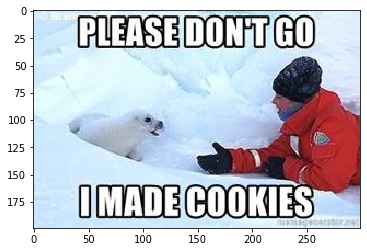

In [8]:
IMG_folder='resized'
img=mpimg.imread(os.path.join(IMG_folder,os.listdir(IMG_folder)[5]))
imgplot = plt.imshow(img)

In [0]:
base_dir = '/content/adl_project/'

os.mkdir(base_dir)

train_dir = os.path.join(base_dir, 'train')
os.mkdir(train_dir) 

validation_dir = os.path.join(base_dir, 'validation')
os.mkdir(validation_dir)

test_dir = os.path.join(base_dir, 'test')
os.mkdir(test_dir)

In [0]:
train_positive_dir = os.path.join(train_dir, 'positive')
os.mkdir(train_positive_dir)

train_negative_dir = os.path.join(train_dir, 'negative')
os.mkdir(train_negative_dir)

train_neutral_dir = os.path.join(train_dir, 'neutral')
os.mkdir(train_neutral_dir)

validation_positive_dir = os.path.join(validation_dir, 'positive')
os.mkdir(validation_positive_dir)

validation_negative_dir = os.path.join(validation_dir, 'negative')
os.mkdir(validation_negative_dir)

validation_neutral_dir = os.path.join(validation_dir, 'neutral')
os.mkdir(validation_neutral_dir)

test_positive_dir = os.path.join(test_dir, 'positive')
os.mkdir(test_positive_dir)

test_negative_dir = os.path.join(test_dir, 'negative')
os.mkdir(test_negative_dir)

test_neutral_dir = os.path.join(test_dir, 'neutral')
os.mkdir(test_neutral_dir)

Changing the 'img_name' column to point to the path pointing to the images in the resized_data folder.

In [0]:
x_test['img_name']=x_test['img_name'].apply(lambda x: os.path.join('resized',x))
x_train['img_name']=x_train['img_name'].apply(lambda x: os.path.join('resized',x))
x_val['img_name']=x_val['img_name'].apply(lambda x: os.path.join('resized',x))

In [12]:
x_test['img_name'][0:5]

0                      resized/barney_f_5126eadc91.jpg
1                          resized/titanic_Vd8HSKb.jpg
2                resized/hillary_hillary-turd-meme.jpg
3    resized/zeck_congress-when-they-finally-get-to...
4    resized/tech_cb67a56a2f0f09ab2a75891ea15c1872.png
Name: img_name, dtype: object

In [13]:
labels_train = x_train['positive_tag'].astype('float32')
labels_test = x_test['positive_tag'].astype('float32')
labels_val = x_val['positive_tag'].astype('float32')

images_train = x_train['img_name']
images_test = x_test['img_name']
images_val = x_val['img_name']

text_train = x_train['text1'].astype('str')
text_test = x_test['text1'].astype('str')
text_val = x_val['text1'].astype('str')


print(len(images_train), len(text_train), len(labels_train))
print(len(images_test), len(text_test), len(labels_test))
print(len(images_val), len(text_val), len(labels_val))


4564 4564 4564
980 980 980
976 976 976


As seen, the data that we are using is imbalanced. We did not perform downsampling because that would reduce the size of our dataset by a substantial amount.

To gauge the performance of the model on this unbalanced dataset, we are using weighted- f1 score as a metric.

This sklearn webpage states how weighted f1 accounts for label inbalance while macro- f1 does not

https://scikit-learn.org/stable/modules/generated/sklearn.metrics.f1_score.html

## Modeling the data

In [14]:
positive_train = x_train[x_train['positive_tag'] == 1.0]
positive_train = positive_train['img_name']
print(len(positive_train))

positive_test = x_test[x_test['positive_tag'] == 1.0]
positive_test = positive_test['img_name']
print(len(positive_test))

positive_val = x_val[x_val['positive_tag'] == 1.0]
positive_val = positive_val['img_name']
print(len(positive_val))

2709
581
580


In [15]:
negative_train = x_train[x_train['positive_tag'] == 2.0]
negative_train = negative_train['img_name']
print(len(negative_train))

negative_test = x_test[x_test['positive_tag'] == 2.0]
negative_test = negative_test['img_name']
print(len(negative_test))

negative_val = x_val[x_val['positive_tag'] == 2.0]
negative_val = negative_val['img_name']
print(len(negative_val))

404
87
86


In [16]:
neutral_train = x_train[x_train['positive_tag'] == 0.0]
neutral_train = neutral_train['img_name']
print(len(neutral_train))

neutral_test = x_test[x_test['positive_tag'] == 0.0]
neutral_test = neutral_test['img_name']
print(len(neutral_test))

neutral_val = x_val[x_val['positive_tag'] == 0.0]
neutral_val = neutral_val['img_name']
print(len(neutral_val))

1451
312
310


In [0]:
local_base_dir = '/content/resized/'

# Copying training images

for i in positive_train:
  src = os.path.join(local_base_dir, i.split("resized/")[1])
  dest = os.path.join(train_positive_dir, i.split("resized/")[1])
  shutil.copyfile(src, dest)

for i in negative_train:
  src = os.path.join(local_base_dir, i.split("resized/")[1])
  dest = os.path.join(train_negative_dir, i.split("resized/")[1])
  shutil.copyfile(src, dest)

for i in neutral_train:
  src = os.path.join(local_base_dir, i.split("resized/")[1])
  dest = os.path.join(train_neutral_dir, i.split("resized/")[1])
  shutil.copyfile(src, dest)


In [0]:
# Copying test images

for i in positive_test:
  src = os.path.join(local_base_dir, i.split("resized/")[1])
  dest = os.path.join(test_positive_dir, i.split("resized/")[1])
  shutil.copyfile(src, dest)


for i in negative_test:
  src = os.path.join(local_base_dir, i.split("resized/")[1])
  dest = os.path.join(test_negative_dir, i.split("resized/")[1])
  shutil.copyfile(src, dest)

for i in neutral_test:
  src = os.path.join(local_base_dir, i.split("resized/")[1])
  dest = os.path.join(test_neutral_dir, i.split("resized/")[1])
  shutil.copyfile(src, dest)


In [0]:
# Copying validation images

for i in positive_val:
  src = os.path.join(local_base_dir, i.split("resized/")[1])
  dest = os.path.join(validation_positive_dir, i.split("resized/")[1])
  shutil.copyfile(src, dest)

for i in negative_val:
  src = os.path.join(local_base_dir, i.split("resized/")[1])
  dest = os.path.join(validation_negative_dir, i.split("resized/")[1])
  shutil.copyfile(src, dest)

for i in neutral_val:
  src = os.path.join(local_base_dir, i.split("resized/")[1])
  dest = os.path.join(validation_neutral_dir, i.split("resized/")[1])
  shutil.copyfile(src, dest)

In [20]:
x_train["positive_tag"].value_counts()

1.0    2709
0.0    1451
2.0     404
Name: positive_tag, dtype: int64

In [0]:
assert len(x_train)==4564
assert len(x_test)==980
assert len(x_val)==976

In [22]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

IMG_SIZE = 299
train_datagen = ImageDataGenerator(rescale=1./255)
train_generator = train_datagen.flow_from_directory(
        train_dir,
        target_size=(IMG_SIZE, IMG_SIZE),
        batch_size=32,
        class_mode='sparse',
        shuffle=False)

Found 4563 images belonging to 3 classes.


In [23]:
train_generator.class_indices

{'negative': 0, 'neutral': 1, 'positive': 2}

In [24]:
for data_batch, labels_batch in train_generator:
    print('data batch shape:', data_batch.shape)
    print('labels batch shape:', labels_batch.shape)
    break

data batch shape: (32, 299, 299, 3)
labels batch shape: (32,)


In [25]:
validation_gen = ImageDataGenerator(rescale=1./255)
validation_generator = validation_gen.flow_from_directory(
              validation_dir,
              target_size=(IMG_SIZE, IMG_SIZE),
              batch_size=32,
              class_mode='sparse',
              shuffle=False)

Found 976 images belonging to 3 classes.


In [26]:
for data_batch, labels_batch in validation_generator:
    print('data batch shape:', data_batch.shape)
    print('labels batch shape:', labels_batch.shape)
    break

data batch shape: (32, 299, 299, 3)
labels batch shape: (32,)


In [27]:
test_gen = ImageDataGenerator(rescale=1./255)
test_generator = test_gen.flow_from_directory(
              test_dir,
              target_size=(IMG_SIZE, IMG_SIZE),
              batch_size=32,
              class_mode='sparse',
              shuffle=False)

Found 980 images belonging to 3 classes.


In [28]:
for data_batch, labels_batch in test_generator:
    print('data batch shape:', data_batch.shape)
    print('labels batch shape:', labels_batch.shape)
    break

data batch shape: (32, 299, 299, 3)
labels batch shape: (32,)


## Image Only

a) Code for analysing whether a meme is positive, negative or neutral using only meme images.

In [0]:
from tensorflow.keras import layers, models

model = models.Sequential()
model.add(layers.Conv2D(32, (3, 3), activation='relu',
                        input_shape=(IMG_SIZE, IMG_SIZE, 3)))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Flatten())

model.add(layers.Dense(3, activation='softmax'))

In [30]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 297, 297, 32)      896       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 148, 148, 32)      0         
_________________________________________________________________
flatten (Flatten)            (None, 700928)            0         
_________________________________________________________________
dense (Dense)                (None, 3)                 2102787   
Total params: 2,103,683
Trainable params: 2,103,683
Non-trainable params: 0
_________________________________________________________________


In [0]:
model.compile(loss='sparse_categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

In [32]:
history = model.fit_generator(train_generator,
                   epochs=10,
                   validation_data=validation_generator,
                   shuffle=True
                   )

Instructions for updating:
Please use Model.fit, which supports generators.
  ...
    to  
  ['...']
  ...
    to  
  ['...']
Train for 143 steps, validate for 31 steps
Epoch 1/10
143/143 [==============================] - 23s 164ms/step - loss: 11.0294 - accuracy: 0.5308 - val_loss: 1.0759 - val_accuracy: 0.5932
Epoch 2/10
143/143 [==============================] - 17s 116ms/step - loss: 0.9139 - accuracy: 0.6145 - val_loss: 0.9435 - val_accuracy: 0.5902
Epoch 3/10
143/143 [==============================] - 16s 115ms/step - loss: 0.6586 - accuracy: 0.7250 - val_loss: 1.2553 - val_accuracy: 0.3678
Epoch 4/10
143/143 [==============================] - 16s 115ms/step - loss: 0.4530 - accuracy: 0.8519 - val_loss: 1.1868 - val_accuracy: 0.5338
Epoch 5/10
143/143 [==============================] - 16s 114ms/step - loss: 0.2549 - accuracy: 0.9347 - val_loss: 1.1460 - val_accuracy: 0.5564
Epoch 6/10
143/143 [==============================] - 16s 113ms/step - loss: 0.1562 - accuracy: 0.9695 - 

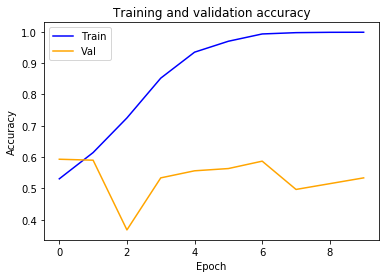

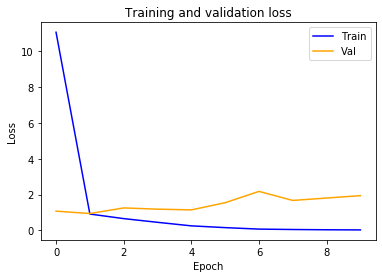

In [34]:
import matplotlib.pyplot as plt

def plot(history):
  
  acc = history.history['accuracy']
  val_acc = history.history['val_accuracy']
  loss = history.history['loss']
  val_loss = history.history['val_loss']

  epochs = range(len(acc))

  plt.title('Training and validation accuracy')
  plt.plot(epochs, acc, color='blue', label='Train')
  plt.plot(epochs, val_acc, color='orange', label='Val')
  plt.xlabel('Epoch')
  plt.ylabel('Accuracy')
  plt.legend()

  _ = plt.figure()
  plt.title('Training and validation loss')
  plt.plot(epochs, loss, color='blue', label='Train')
  plt.plot(epochs, val_loss, color='orange', label='Val')
  plt.xlabel('Epoch')
  plt.ylabel('Loss')
  plt.legend()
  
plot(history)

In [35]:
filenames = test_generator.filenames
nb_samples = len(filenames)
print(nb_samples)

980


In [36]:
# evaluate on test data
predict = model.predict_generator(test_generator)

Instructions for updating:
Please use Model.predict, which supports generators.


In [37]:
y_pred=np.argmax(predict, axis=1)
y_pred[0:5]

array([2, 2, 1, 2, 2])

In [38]:
x_test['positive_tag'][0:5]

0    1.0
1    1.0
2    1.0
3    1.0
4    1.0
Name: positive_tag, dtype: float64

In [39]:
from sklearn.metrics import precision_recall_fscore_support, classification_report
print(precision_recall_fscore_support(test_generator.classes, y_pred, average='macro'))
print(precision_recall_fscore_support(test_generator.classes, y_pred, average='weighted'))

(0.3021636029675549, 0.32906534563161066, 0.31260283254306653, None)
(0.45012969252016966, 0.5122448979591837, 0.47646586239845734, None)


In [40]:
print(classification_report(test_generator.classes, y_pred))

              precision    recall  f1-score   support

           0       0.00      0.00      0.00        87
           1       0.32      0.27      0.29       312
           2       0.59      0.72      0.65       581

    accuracy                           0.51       980
   macro avg       0.30      0.33      0.31       980
weighted avg       0.45      0.51      0.48       980



Using a more complex model on the same dataset

In [0]:
from tensorflow.keras import layers, models


model = models.Sequential()
model.add(layers.Conv2D(32, (3, 3), activation='relu',
                        input_shape=(IMG_SIZE, IMG_SIZE, 3)))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Flatten())
model.add(layers.Dense(128, activation='relu'))
model.add(layers.Dropout(0.5))
model.add(layers.Dense(64, activation='relu'))

model.add(layers.Dense(3, activation='softmax'))


In [0]:
model.compile(loss='sparse_categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

In [43]:
history = model.fit_generator(train_generator,
                   epochs=10,
                   validation_data=validation_generator,
                   shuffle=True
                   )

  ...
    to  
  ['...']
  ...
    to  
  ['...']
Train for 143 steps, validate for 31 steps
Epoch 1/10
143/143 [==============================] - 19s 130ms/step - loss: 10.1785 - accuracy: 0.5065 - val_loss: 0.9519 - val_accuracy: 0.5932
Epoch 2/10
143/143 [==============================] - 18s 125ms/step - loss: 0.9657 - accuracy: 0.5713 - val_loss: 0.9763 - val_accuracy: 0.5922
Epoch 3/10
143/143 [==============================] - 18s 124ms/step - loss: 0.9289 - accuracy: 0.5915 - val_loss: 0.9264 - val_accuracy: 0.5902
Epoch 4/10
143/143 [==============================] - 18s 124ms/step - loss: 0.9145 - accuracy: 0.5928 - val_loss: 0.9121 - val_accuracy: 0.5943
Epoch 5/10
143/143 [==============================] - 18s 127ms/step - loss: 0.9635 - accuracy: 0.5928 - val_loss: 0.9258 - val_accuracy: 0.5943
Epoch 6/10
143/143 [==============================] - 18s 125ms/step - loss: 0.8837 - accuracy: 0.5961 - val_loss: 0.9086 - val_accuracy: 0.5953
Epoch 7/10
143/143 [================

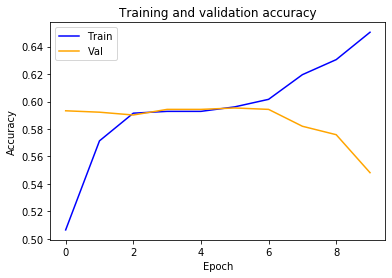

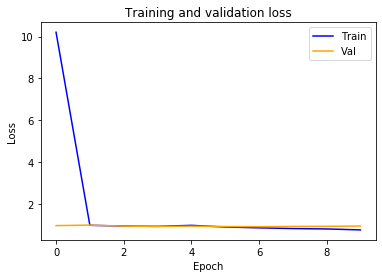

In [44]:
plot(history)

In [45]:
filenames = test_generator.filenames
nb_samples = len(filenames)
print(nb_samples)

980


In [0]:
predict = model.predict_generator(test_generator)
y_pred=np.argmax(predict, axis=1)

In [47]:
from sklearn.metrics import precision_recall_fscore_support, classification_report
print(precision_recall_fscore_support(test_generator.classes, y_pred, average='macro'))
print(precision_recall_fscore_support(test_generator.classes, y_pred, average='weighted'))

(0.316620148856991, 0.34020146520146516, 0.3088592157882356, None)
(0.4659164144126551, 0.560204081632653, 0.4879291433544038, None)


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


In [48]:
print(classification_report(test_generator.classes, y_pred))

              precision    recall  f1-score   support

           0       0.00      0.00      0.00        87
           1       0.35      0.16      0.22       312
           2       0.60      0.86      0.70       581

    accuracy                           0.56       980
   macro avg       0.32      0.34      0.31       980
weighted avg       0.47      0.56      0.49       980



/usr/local/lib/python3.6/dist-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


Using image augmentation on same dataset. We have rotated the image by 10 degrees and applied shearing by a factor of 0.1.



In [49]:
train_datagen = ImageDataGenerator(rescale=1./255,
                                   shear_range=0.1,
                                   rotation_range=10)
train_generator = train_datagen.flow_from_directory(
        train_dir,
        target_size=(IMG_SIZE, IMG_SIZE),
        batch_size=32,
        class_mode='sparse',
        shuffle=False)



Found 4563 images belonging to 3 classes.


In [50]:
validation_gen = ImageDataGenerator(rescale=1./255,
                                   shear_range=0.1,
                                   rotation_range=10)
validation_generator = validation_gen.flow_from_directory(
              validation_dir,
              target_size=(IMG_SIZE, IMG_SIZE),
              batch_size=32,
              class_mode='sparse',
              shuffle=False)


Found 976 images belonging to 3 classes.


In [51]:
test_gen = ImageDataGenerator(rescale=1./255)
test_generator = test_gen.flow_from_directory(
              test_dir,
              target_size=(IMG_SIZE, IMG_SIZE),
              batch_size=32,
              class_mode='sparse',
              shuffle=False)

Found 980 images belonging to 3 classes.


In [0]:
model = models.Sequential()
model.add(layers.Conv2D(32, (3, 3), activation='relu',
                        input_shape=(IMG_SIZE, IMG_SIZE, 3)))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Flatten())

model.add(layers.Dense(3, activation='softmax'))

In [0]:
model.compile(loss='sparse_categorical_crossentropy',
              optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
              metrics=['accuracy'])

In [62]:
history = model.fit_generator(train_generator,
                   epochs=10,
                   validation_data=validation_generator,
                   shuffle=True
                   )

  ...
    to  
  ['...']
  ...
    to  
  ['...']
Train for 143 steps, validate for 31 steps
Epoch 1/10
143/143 [==============================] - 109s 764ms/step - loss: 1.7365 - accuracy: 0.5047 - val_loss: 1.2192 - val_accuracy: 0.5943
Epoch 2/10
143/143 [==============================] - 109s 761ms/step - loss: 1.2347 - accuracy: 0.5411 - val_loss: 1.1425 - val_accuracy: 0.5943
Epoch 3/10
143/143 [==============================] - 109s 759ms/step - loss: 1.0745 - accuracy: 0.4992 - val_loss: 0.9475 - val_accuracy: 0.5943
Epoch 4/10
143/143 [==============================] - 107s 748ms/step - loss: 0.9267 - accuracy: 0.5810 - val_loss: 1.0290 - val_accuracy: 0.3402
Epoch 5/10
143/143 [==============================] - 107s 746ms/step - loss: 0.9388 - accuracy: 0.5737 - val_loss: 0.9107 - val_accuracy: 0.5891
Epoch 6/10
143/143 [==============================] - 106s 740ms/step - loss: 0.9270 - accuracy: 0.5687 - val_loss: 0.9113 - val_accuracy: 0.5891
Epoch 7/10
143/143 [===========

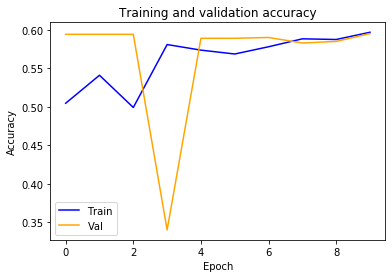

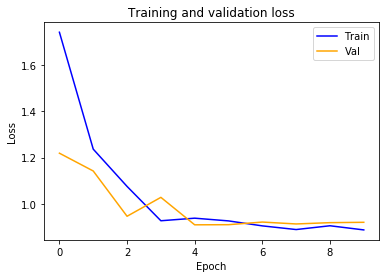

In [63]:
plot(history)

In [0]:
predict = model.predict_generator(test_generator)
y_pred=np.argmax(predict, axis=1)

In [65]:
from sklearn.metrics import precision_recall_fscore_support, classification_report
print(precision_recall_fscore_support(test_generator.classes, y_pred, average='macro'))
print(precision_recall_fscore_support(test_generator.classes, y_pred, average='weighted'))

(0.2927689594356261, 0.33260146814363684, 0.25144308955397615, None)
(0.4422848504481157, 0.5897959183673469, 0.44376761667370335, None)


In [66]:
print(classification_report(test_generator.classes, y_pred))

              precision    recall  f1-score   support

           0       0.00      0.00      0.00        87
           1       0.29      0.01      0.01       312
           2       0.59      0.99      0.74       581

    accuracy                           0.59       980
   macro avg       0.29      0.33      0.25       980
weighted avg       0.44      0.59      0.44       980



More complex model trained on augmented images

In [0]:
model = models.Sequential()
model.add(layers.Conv2D(32, (3, 3), activation='relu',
                        input_shape=(IMG_SIZE, IMG_SIZE, 3)))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Flatten())
model.add(layers.Dense(128, activation='relu'))
model.add(layers.Dropout(0.5))
model.add(layers.Dense(64, activation='relu'))

model.add(layers.Dense(3, activation='softmax'))


In [0]:
model.compile(loss='sparse_categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])


In [69]:
history = model.fit_generator(train_generator,
                   epochs=10,
                   validation_data=validation_generator,
                   shuffle=True
                   )

  ...
    to  
  ['...']
  ...
    to  
  ['...']
Train for 143 steps, validate for 31 steps
Epoch 1/10
143/143 [==============================] - 106s 740ms/step - loss: 16.5594 - accuracy: 0.4438 - val_loss: 0.9576 - val_accuracy: 0.5912
Epoch 2/10
143/143 [==============================] - 106s 738ms/step - loss: 1.0227 - accuracy: 0.5382 - val_loss: 0.9527 - val_accuracy: 0.5963
Epoch 3/10
143/143 [==============================] - 109s 761ms/step - loss: 0.9745 - accuracy: 0.5632 - val_loss: 0.9327 - val_accuracy: 0.5943
Epoch 4/10
143/143 [==============================] - 110s 770ms/step - loss: 0.9484 - accuracy: 0.5781 - val_loss: 0.9206 - val_accuracy: 0.5943
Epoch 5/10
143/143 [==============================] - 111s 775ms/step - loss: 0.9281 - accuracy: 0.5847 - val_loss: 0.9010 - val_accuracy: 0.5943
Epoch 6/10
143/143 [==============================] - 111s 779ms/step - loss: 1.1857 - accuracy: 0.5856 - val_loss: 0.8985 - val_accuracy: 0.5932
Epoch 7/10
143/143 [==========

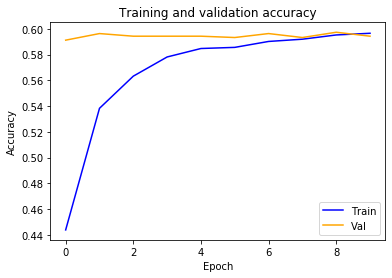

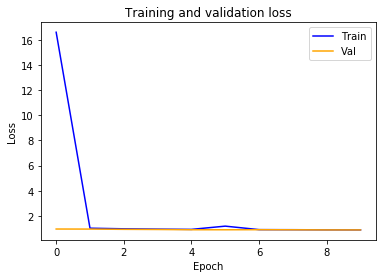

In [70]:
plot(history)

In [0]:
predict = model.predict_generator(test_generator)
y_pred=np.argmax(predict, axis=1)


In [72]:
from sklearn.metrics import precision_recall_fscore_support, classification_report
print(precision_recall_fscore_support(test_generator.classes, y_pred, average='macro'))
print(precision_recall_fscore_support(test_generator.classes, y_pred, average='weighted'))


(0.30892083048140545, 0.3337489150742163, 0.25199565882693953, None)
(0.4579411641453296, 0.5918367346938775, 0.44473957707817696, None)


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


In [73]:
print(classification_report(test_generator.classes, y_pred))

              precision    recall  f1-score   support

           0       0.00      0.00      0.00        87
           1       0.33      0.01      0.01       312
           2       0.59      0.99      0.74       581

    accuracy                           0.59       980
   macro avg       0.31      0.33      0.25       980
weighted avg       0.46      0.59      0.44       980



/usr/local/lib/python3.6/dist-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


## Text based models

In [0]:
text_train = x_train['text1'].astype('str').values
text_test = x_test['text1'].astype('str').values
text_val = x_val['text1'].astype('str').values

In [75]:
VOCAB_SIZE = 3000 # vocabulary size
tokenizer = tf.keras.preprocessing.text.Tokenizer(num_words=VOCAB_SIZE)
tokenizer.fit_on_texts(text_train)

print("Word index", len(tokenizer.word_index))

Word index 7116


Converting text to sequences and padding it

In [0]:
sequences_train = tokenizer.texts_to_sequences(text_train)
sequences_val = tokenizer.texts_to_sequences(text_val)
sequences_test = tokenizer.texts_to_sequences(text_test)

In [0]:
MAX_SEQ_LEN = 20
padded_train = tf.keras.preprocessing.sequence.pad_sequences(sequences_train, MAX_SEQ_LEN)
padded_val = tf.keras.preprocessing.sequence.pad_sequences(sequences_val, MAX_SEQ_LEN)
padded_test = tf.keras.preprocessing.sequence.pad_sequences(sequences_test, MAX_SEQ_LEN)

In [78]:
from tensorflow.keras.utils import to_categorical

labels_train1 = to_categorical(labels_train)
labels_test1 = to_categorical(labels_test)
labels_val1 = to_categorical(labels_val)

print(labels_train1.shape, labels_val1.shape, labels_test1.shape)

(4564, 3) (976, 3) (980, 3)


In [0]:
from tensorflow.keras.layers import Embedding
EMBEDDING_DIM = 300

embedding_layer = Embedding(len(tokenizer.word_index) + 1,
                            EMBEDDING_DIM,
                            weights=None,
                            input_length=MAX_SEQ_LEN,
                            trainable=False)

In [0]:
from tensorflow.keras.layers import Bidirectional, GlobalMaxPool1D, Conv1D
from tensorflow.keras.layers import Dense, Input, LSTM, Embedding, Dropout, Activation, TimeDistributed, Flatten
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

inp = Input(shape=(MAX_SEQ_LEN,))
x = embedding_layer(inp)

x = LSTM(32)(x)
x = Dense(3, activation="softmax")(x)
model = Model(inputs=inp, outputs=x)

In [0]:
model.compile('adam', 'categorical_crossentropy', metrics=['accuracy'])


In [101]:
history = model.fit(padded_train, labels_train1, validation_data=[padded_val, labels_val1], epochs=10)

Train on 4564 samples, validate on 976 samples
Epoch 1/10
4564/4564 [==============================] - 2s 451us/sample - loss: 0.9144 - accuracy: 0.5907 - val_loss: 0.8895 - val_accuracy: 0.5943
Epoch 2/10
4564/4564 [==============================] - 1s 171us/sample - loss: 0.8876 - accuracy: 0.5936 - val_loss: 0.8891 - val_accuracy: 0.5943
Epoch 3/10
4564/4564 [==============================] - 1s 166us/sample - loss: 0.8848 - accuracy: 0.5936 - val_loss: 0.8913 - val_accuracy: 0.5943
Epoch 4/10
4564/4564 [==============================] - 1s 177us/sample - loss: 0.8826 - accuracy: 0.5936 - val_loss: 0.8902 - val_accuracy: 0.5943
Epoch 5/10
4564/4564 [==============================] - 1s 171us/sample - loss: 0.8805 - accuracy: 0.5936 - val_loss: 0.8907 - val_accuracy: 0.5943
Epoch 6/10
4564/4564 [==============================] - 1s 172us/sample - loss: 0.8777 - accuracy: 0.5936 - val_loss: 0.8947 - val_accuracy: 0.5943
Epoch 7/10
4564/4564 [==============================] - 1s 166us/

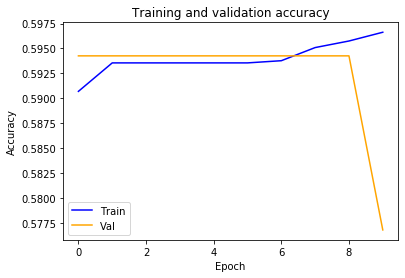

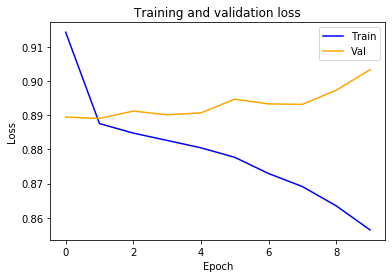

In [102]:
plot(history)

In [0]:
y_pred = model.predict(padded_test)

In [0]:
y_pred=np.argmax(y_pred, axis=1)

In [105]:
from sklearn.metrics import precision_recall_fscore_support
print(precision_recall_fscore_support(x_test['positive_tag'], y_pred, average='macro'))
print(precision_recall_fscore_support(x_test['positive_tag'], y_pred, average='weighted'))

(0.30621442495126705, 0.3335337687747326, 0.2969952129931222, None)
(0.4545915741735291, 0.5571428571428572, 0.476721105823435, None)


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


In [106]:
from sklearn.metrics import classification_report
print(classification_report(x_test['positive_tag'], y_pred))

              precision    recall  f1-score   support

         0.0       0.33      0.13      0.19       312
         1.0       0.59      0.87      0.70       581
         2.0       0.00      0.00      0.00        87

    accuracy                           0.56       980
   macro avg       0.31      0.33      0.30       980
weighted avg       0.45      0.56      0.48       980



/usr/local/lib/python3.6/dist-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


In [0]:
inp = Input(shape=(MAX_SEQ_LEN,))
x = embedding_layer(inp)

x = Bidirectional(LSTM(128, return_sequences=True))(x)
x = GlobalMaxPool1D()(x)
x = Dense(3, activation="softmax")(x)
model = Model(inputs=inp, outputs=x)

Train on 4564 samples, validate on 976 samples
Epoch 1/10
4564/4564 [==============================] - 4s 822us/sample - loss: 0.9043 - accuracy: 0.5925 - val_loss: 0.8950 - val_accuracy: 0.5943
Epoch 2/10
4564/4564 [==============================] - 1s 265us/sample - loss: 0.8908 - accuracy: 0.5936 - val_loss: 0.8895 - val_accuracy: 0.5943
Epoch 3/10
4564/4564 [==============================] - 1s 268us/sample - loss: 0.8854 - accuracy: 0.5936 - val_loss: 0.8902 - val_accuracy: 0.5943
Epoch 4/10
4564/4564 [==============================] - 1s 262us/sample - loss: 0.8794 - accuracy: 0.5936 - val_loss: 0.8950 - val_accuracy: 0.5943
Epoch 5/10
4564/4564 [==============================] - 1s 263us/sample - loss: 0.8713 - accuracy: 0.5942 - val_loss: 0.8892 - val_accuracy: 0.5943
Epoch 6/10
4564/4564 [==============================] - 1s 263us/sample - loss: 0.8621 - accuracy: 0.5957 - val_loss: 0.8954 - val_accuracy: 0.5881
Epoch 7/10
4564/4564 [==============================] - 1s 263us/

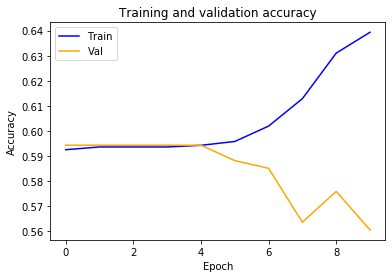

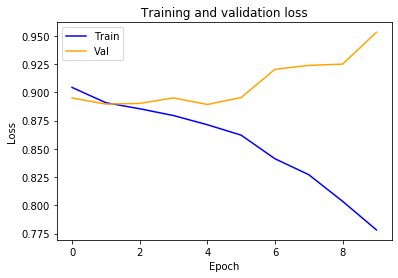

In [123]:
model.compile('adam', 'categorical_crossentropy', metrics=['accuracy'])
history = model.fit(padded_train, labels_train1, validation_data=[padded_val, labels_val1], epochs=10)
plot(history)

In [0]:
y_pred = model.predict(padded_test)
y_pred=np.argmax(y_pred, axis=1)

In [125]:
from sklearn.metrics import precision_recall_fscore_support, classification_report
print(precision_recall_fscore_support(x_test['positive_tag'], y_pred, average='macro'))
print(precision_recall_fscore_support(x_test['positive_tag'], y_pred, average='weighted'))

(0.34928627743889784, 0.33876962948421196, 0.3143972421511414, None)
(0.46478032368181926, 0.5459183673469388, 0.4761238300797183, None)


In [126]:
print(classification_report(x_test['positive_tag'], y_pred))

              precision    recall  f1-score   support

         0.0       0.32      0.12      0.18       312
         1.0       0.59      0.85      0.70       581
         2.0       0.14      0.05      0.07        87

    accuracy                           0.55       980
   macro avg       0.35      0.34      0.31       980
weighted avg       0.46      0.55      0.48       980



In [0]:
correct_preds=[]
incorrect_preds=[]
for i in range(len(labels_test)):
  if labels_test[i]==y_pred[i]:
    correct_preds.append(i)
  else:
    incorrect_preds.append(i)

Prediction: Positive
Actual: Positive


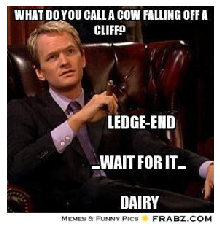

In [162]:
my_dict={0:'Neutral',1:'Positive',2:'Negative'}
i=correct_preds[0]
img=plt.imread(images_test[i], 0)
img_final = tf.image.resize(img, [299,299])
print("Prediction:", my_dict[int(y_pred[i])])
print("Actual:", my_dict[int(labels_test[i])])
plt.axis('off')
_=plt.imshow(img)

Prediction: Negative
Actual: Positive


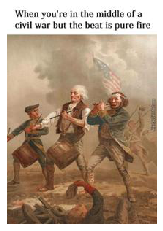

In [169]:
my_dict={0:'Neutral',1:'Positive',2:'Negative'}
i=incorrect_preds[80]
img=plt.imread(images_test[i], 0)
img_final = tf.image.resize(img, [299,299])
print("Prediction:", my_dict[int(y_pred[i])])
print("Actual:", my_dict[int(labels_test[i])])
plt.axis('off')
_=plt.imshow(img)


Using 300 dimensional Glove Embeddings as weights for the Embedding layer 

In [127]:
GLOVE_DIR='drive/My Drive/yelp_review_polarity_csv/'

import os
embeddings_index = {}
f = open(os.path.join(GLOVE_DIR, 'glove.42B.300d.txt'))
for line in f:
    values = line.split()
    word = values[0]
    coefs = np.asarray(values[1:], dtype='float32')
    embeddings_index[word] = coefs
f.close()

print('Found %s word vectors.' % len(embeddings_index))

Found 1917494 word vectors.


In [0]:
EMBEDDING_DIM = 300 # how big is each word vector

embedding_matrix = np.zeros((len(tokenizer.word_index) + 1, EMBEDDING_DIM))
for word, i in tokenizer.word_index.items():
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        # words not found in embedding index will be all-zeros.
        embedding_matrix[i] = embedding_vector

In [0]:
from tensorflow.keras.layers import Embedding

embedding_layer = Embedding(len(tokenizer.word_index) + 1,
                            EMBEDDING_DIM,
                            weights=[embedding_matrix],
                            input_length=MAX_SEQ_LEN,
                            trainable=False)

In [0]:
inp = Input(shape=(MAX_SEQ_LEN,))
x = embedded_sequences = embedding_layer(inp)

x = Bidirectional(LSTM(128, return_sequences=True, dropout=0.2, recurrent_dropout=0.1))(x)
x = GlobalMaxPool1D()(x)
x = Dense(3, activation="softmax")(x)
model = Model(inputs=inp, outputs=x)

Train on 4564 samples, validate on 976 samples
Epoch 1/10
4564/4564 [==============================] - 15s 3ms/sample - loss: 0.9077 - accuracy: 0.5881 - val_loss: 0.8977 - val_accuracy: 0.5912
Epoch 2/10
4564/4564 [==============================] - 11s 2ms/sample - loss: 0.8727 - accuracy: 0.5951 - val_loss: 0.9026 - val_accuracy: 0.5953
Epoch 3/10
4564/4564 [==============================] - 11s 2ms/sample - loss: 0.8473 - accuracy: 0.6036 - val_loss: 0.9074 - val_accuracy: 0.5943
Epoch 4/10
4564/4564 [==============================] - 11s 2ms/sample - loss: 0.8210 - accuracy: 0.6223 - val_loss: 0.9212 - val_accuracy: 0.5820
Epoch 5/10
4564/4564 [==============================] - 11s 2ms/sample - loss: 0.7854 - accuracy: 0.6400 - val_loss: 0.9207 - val_accuracy: 0.5840
Epoch 6/10
4564/4564 [==============================] - 11s 2ms/sample - loss: 0.7391 - accuracy: 0.6711 - val_loss: 0.9483 - val_accuracy: 0.5758
Epoch 7/10
4564/4564 [==============================] - 10s 2ms/sample 

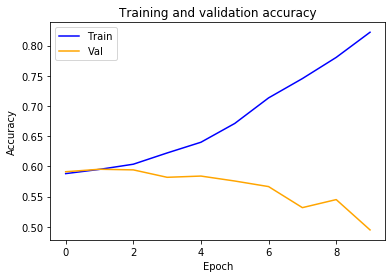

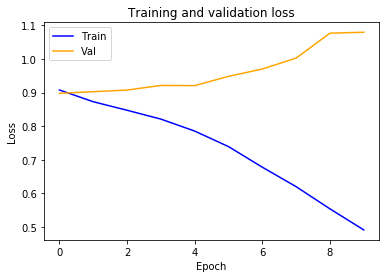

In [177]:
model.compile('adam', 'categorical_crossentropy', metrics=['accuracy'])
history = model.fit(padded_train, labels_train1, validation_data=[padded_val, labels_val1], epochs=10)
plot(history)

In [0]:
y_pred = model.predict(padded_test)
y_pred=np.argmax(y_pred, axis=1)

In [179]:
from sklearn.metrics import precision_recall_fscore_support
print(precision_recall_fscore_support(x_test['positive_tag'], y_pred, average='macro'))
print(precision_recall_fscore_support(x_test['positive_tag'], y_pred, average='weighted'))

(0.32848651623555314, 0.32415483583950555, 0.3130114987231406, None)
(0.44974435321734635, 0.46428571428571436, 0.45236438387514966, None)


In [181]:
from sklearn.metrics import classification_report
print(classification_report(x_test['positive_tag'], y_pred))

              precision    recall  f1-score   support

         0.0       0.31      0.39      0.34       312
         1.0       0.58      0.57      0.58       581
         2.0       0.10      0.01      0.02        87

    accuracy                           0.46       980
   macro avg       0.33      0.32      0.31       980
weighted avg       0.45      0.46      0.45       980



In [0]:
inp = Input(shape=(MAX_SEQ_LEN,))
x = embedding_layer(inp)

x = LSTM(128)(x)
x = Dense(3, activation="softmax")(x)
model = Model(inputs=inp, outputs=x)


Train on 4564 samples, validate on 976 samples
Epoch 1/10
4564/4564 [==============================] - 2s 481us/sample - loss: 0.9042 - accuracy: 0.5865 - val_loss: 0.8982 - val_accuracy: 0.5943
Epoch 2/10
4564/4564 [==============================] - 1s 195us/sample - loss: 0.8673 - accuracy: 0.5984 - val_loss: 0.8974 - val_accuracy: 0.5932
Epoch 3/10
4564/4564 [==============================] - 1s 188us/sample - loss: 0.8407 - accuracy: 0.6047 - val_loss: 0.9227 - val_accuracy: 0.5881
Epoch 4/10
4564/4564 [==============================] - 1s 184us/sample - loss: 0.8051 - accuracy: 0.6321 - val_loss: 0.9399 - val_accuracy: 0.5748
Epoch 5/10
4564/4564 [==============================] - 1s 189us/sample - loss: 0.7443 - accuracy: 0.6700 - val_loss: 0.9781 - val_accuracy: 0.5174
Epoch 6/10
4564/4564 [==============================] - 1s 184us/sample - loss: 0.6549 - accuracy: 0.7147 - val_loss: 1.0294 - val_accuracy: 0.5594
Epoch 7/10
4564/4564 [==============================] - 1s 189us/

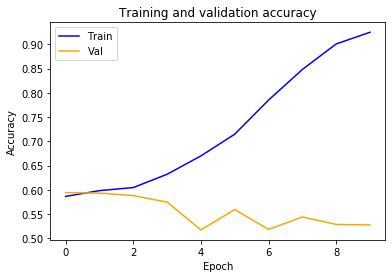

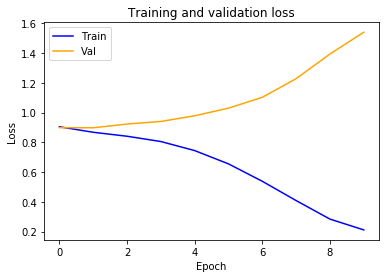

In [184]:
model.compile('adam', 'categorical_crossentropy', metrics=['accuracy'])
history = model.fit(padded_train, labels_train1, validation_data=[padded_val, labels_val1], epochs=10)
plot(history)

In [0]:
y_pred = model.predict(padded_test)
y_pred=np.argmax(y_pred, axis=1)

In [186]:
from sklearn.metrics import precision_recall_fscore_support
print(precision_recall_fscore_support(x_test['positive_tag'], y_pred, average='macro'))
print(precision_recall_fscore_support(x_test['positive_tag'], y_pred, average='weighted'))
from sklearn.metrics import classification_report
print(classification_report(x_test['positive_tag'], y_pred))

(0.336895215417119, 0.33221118654230414, 0.3265991440776707, None)
(0.45939151235659725, 0.4969387755102041, 0.4743472429358456, None)
              precision    recall  f1-score   support

         0.0       0.31      0.28      0.29       312
         1.0       0.59      0.68      0.64       581
         2.0       0.11      0.03      0.05        87

    accuracy                           0.50       980
   macro avg       0.34      0.33      0.33       980
weighted avg       0.46      0.50      0.47       980



In [0]:
inp = Input(shape=(MAX_SEQ_LEN,))
x = embedding_layer(inp)

x = LSTM(128)(x)
x = Dense(32)(x)
x = Dense(3, activation="softmax")(x)
model = Model(inputs=inp, outputs=x)


Train on 4564 samples, validate on 976 samples
Epoch 1/10
4564/4564 [==============================] - 2s 477us/sample - loss: 0.9073 - accuracy: 0.5813 - val_loss: 0.9038 - val_accuracy: 0.5912
Epoch 2/10
4564/4564 [==============================] - 1s 189us/sample - loss: 0.8710 - accuracy: 0.5942 - val_loss: 0.9092 - val_accuracy: 0.5840
Epoch 3/10
4564/4564 [==============================] - 1s 190us/sample - loss: 0.8446 - accuracy: 0.6074 - val_loss: 0.9140 - val_accuracy: 0.5789
Epoch 4/10
4564/4564 [==============================] - 1s 189us/sample - loss: 0.8064 - accuracy: 0.6306 - val_loss: 0.9380 - val_accuracy: 0.5543
Epoch 5/10
4564/4564 [==============================] - 1s 193us/sample - loss: 0.7365 - accuracy: 0.6619 - val_loss: 1.0015 - val_accuracy: 0.5143
Epoch 6/10
4564/4564 [==============================] - 1s 196us/sample - loss: 0.6324 - accuracy: 0.7169 - val_loss: 1.1560 - val_accuracy: 0.5430
Epoch 7/10
4564/4564 [==============================] - 1s 192us/

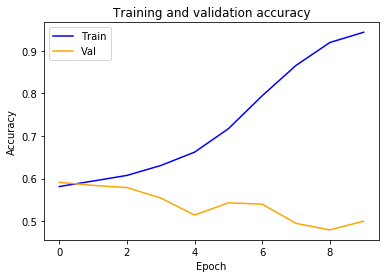

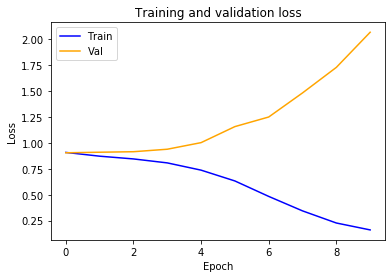

In [188]:
model.compile('adam', 'categorical_crossentropy', metrics=['accuracy'])
history = model.fit(padded_train, labels_train1, validation_data=[padded_val, labels_val1], epochs=10)
plot(history)

In [0]:
y_pred = model.predict(padded_test)
y_pred=np.argmax(y_pred, axis=1)

In [190]:
from sklearn.metrics import precision_recall_fscore_support
print(precision_recall_fscore_support(x_test['positive_tag'], y_pred, average='macro'))
print(precision_recall_fscore_support(x_test['positive_tag'], y_pred, average='weighted'))
from sklearn.metrics import classification_report
print(classification_report(x_test['positive_tag'], y_pred))

(0.35849599538016813, 0.35595178490899304, 0.35603653920485606, None)
(0.48167145209512574, 0.5, 0.48975875482240405, None)
              precision    recall  f1-score   support

         0.0       0.33      0.29      0.31       312
         1.0       0.62      0.67      0.64       581
         2.0       0.13      0.10      0.12        87

    accuracy                           0.50       980
   macro avg       0.36      0.36      0.36       980
weighted avg       0.48      0.50      0.49       980



In [0]:
correct_preds=[]
incorrect_preds=[]
for i in range(len(labels_test)):
  if labels_test[i]==y_pred[i]:
    correct_preds.append(i)
  else:
    incorrect_preds.append(i)


Prediction: Positive
Actual: Positive


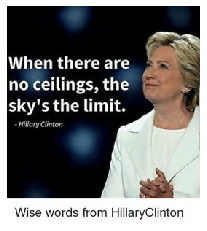

In [194]:
my_dict={0:'Negative',1:'Positive',2:'Neutral'}
i=correct_preds[20]
img=plt.imread(images_test[i], 0)
img_final = tf.image.resize(img, [299,299])
print("Prediction:", my_dict[int(y_pred[i])])
print("Actual:", my_dict[int(labels_test[i])])
plt.axis('off')
_=plt.imshow(img)


Prediction: Positive
Actual: Positive


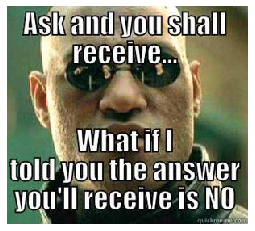

In [209]:
i=correct_preds[9]
img=plt.imread(images_test[i], 0)
img_final = tf.image.resize(img, [299,299])
print("Prediction:", my_dict[int(y_pred[i])])
print("Actual:", my_dict[int(labels_test[i])])
plt.axis('off')
_=plt.imshow(img)


Prediction: Negative
Actual: Positive


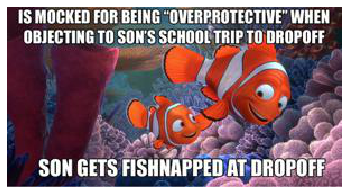

In [215]:
i=incorrect_preds[10]
img=plt.imread(images_test[i], 0)
img_final = tf.image.resize(img, [299,299])
print("Prediction:", my_dict[int(y_pred[i])])
print("Actual:", my_dict[int(labels_test[i])])
plt.axis('off')
_=plt.imshow(img)


Prediction: Negative
Actual: Positive


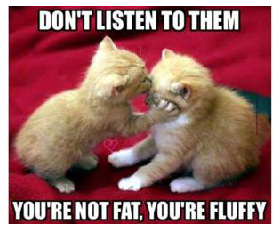

In [217]:
i=incorrect_preds[99]
img=plt.imread(images_test[i], 0)
img_final = tf.image.resize(img, [299,299])
print("Prediction:", my_dict[int(y_pred[i])])
print("Actual:", my_dict[int(labels_test[i])])
plt.axis('off')
_=plt.imshow(img)
